In [102]:
# Standard Python libraries
import os

import time
import warnings
from IPython.display import clear_output

# Data manipulation and numerical libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import asyncio
import dataframe_image as dfi

# Scikit-learn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import roc_auc_score, classification_report

# Qiskit Core
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, ZFeatureMap
from qiskit.primitives import Sampler

# Qiskit Algorithms
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

# Qiskit Machine Learning
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier,VQC
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import PegasosQSVC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
# Qiskit Runtime
from qiskit_ibm_runtime import Session, QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeManilaV2


In [103]:
def setup_environment():
    """Set up the environment with necessary configurations."""
    warnings.filterwarnings("ignore")
    pd.set_option("display.max_rows", None)
    plt.style.use('ggplot')
    algorithm_globals.random_seed = 12345

In [104]:
# **Important:** Modify these constants to configure the script for your specific dataset and experiment.

DATASET_PATH = "datasets/heart.csv"  # Path to your CSV dataset file
TARGET_COLUMN = "HeartDisease"  # Name of the column you want to predict
FEATURE_COUNTS = [10]  # List of feature counts to evaluate
CROSS_VALIDATION_FOLDS = 2  # Number of cross-validation folds
HANDLE_IMBALANCE = 'smote'  # Method to handle class imbalance: 'smote', 'undersample', or None
IMBALANCE_THRESHOLD = 0.7  # Ratio of majority/minority class to trigger imbalance handling
USE_FAKE_QUANTUM = True  # Set to True to use a real quantum computer (requires Qiskit Runtime setup)
OUTPUT_FILE = "results.csv"  # Output file to save the results
VERBOSE = True  # Set to True for more detailed output during execution
MY_IBM_TOKEN= os.environ.get('MY_IBM_QUANTUM_TOKEN')

# Plot saving configuration
SAVE_PLOTS = True  # Toggle to enable/disable plot saving
PLOT_DIR = "plots"  # Directory to save plots
PLOT_FORMAT = "png"  # File format (png, pdf, svg, etc.)
PLOT_DPI = 300  # Resolution for saved plots
PLOT_PREFIX = f"{TARGET_COLUMN.lower()}_"  # Prefix for plot filenames

# Dictionary saving configuration
SAVE_DICT = True  # Toggle to enable/disable dictionary saving
DICT_DIR = "results"  # Directory to save dictionary files  
DICT_FORMAT = "json"  # Options: "json", "pretty", "custom"
DICT_PREFIX = f"{TARGET_COLUMN.lower()}_{FEATURE_COUNTS[-1]}"  # Prefix for filenames
INCLUDE_TIMESTAMP = True  # Add timestamp to filename
INCLUDE_FEATURES = True  # Add feature count to filename



In [105]:
# Set up the IBM Quantum service account
QiskitRuntimeService.save_account(channel="ibm_quantum", token=MY_IBM_TOKEN, overwrite=True)

In [106]:
def load_and_preprocess_data(dataset_path, target_column, imbalance_threshold=0.7, verbose=False):
    """Loads, preprocesses, and splits the data, handling class imbalance.

    Args:
        dataset_path (str): Path to the CSV dataset.
        target_column (str): Name of the target column.
        imbalance_threshold (float): Ratio of majority to minority class to trigger imbalance handling.
        verbose (bool): Print additional debugging information.

    Returns:
        tuple: (X, y, feature_names) - features, target, and original feature names.
        Or None if significant imbalance is detected and no handling method is specified.
    """
    try:
        df = pd.read_csv(dataset_path)
    except FileNotFoundError:
        raise FileNotFoundError(f"Dataset not found at {dataset_path}")

    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in dataset.")

    # --- Handle Missing Values (Flexible Approach) ---
    for col in df.columns:
        if df[col].isnull().any():
            if verbose:
                print(f"Column '{col}' has missing values.")
            if df.shape[0] > 10000:
                # Drop rows with missing values if dataset is large
                df.dropna(inplace=True)
            elif df[col].dtype == 'object' or df[col].dtype == 'string':
                # Fill categorical with most frequent
                df[col] = df[col].fillna(df[col].mode()[0])
            else:
                # Fill numerical with median
                df[col] = df[col].fillna(df[col].median())
    print(f"Dataset's shape is: {df.shape}")

    # --- Identify and Encode Categorical Columns ---
    categorical_cols = []
    for col in df.columns:
        if df[col].dtype == 'object' or df[col].dtype == 'string':
            categorical_cols.append(col)
            if verbose:
                print(f"Treating column '{col}' as categorical.")
            # Ensure type consistency before encoding
            df[col] = df[col].astype(str)
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])

    feature_names = df.drop(columns=[target_column]).columns.tolist()
    X = df.drop(columns=[target_column]).values
    y = df[target_column].values

    # --- Detect Class Imbalance ---
    class_counts = Counter(y)
    majority_class_count = max(class_counts.values())
    imbalance_ratio = majority_class_count / y.shape[0]

    need_to_handle_imbalance= False
    if imbalance_ratio > imbalance_threshold:
        print(f"Significant class imbalance detected (ratio: {imbalance_ratio:.2f}).")
        print("Please specify the 'HANDLE_IMBALANCE' constant ('smote' or 'undersample').")
        need_to_handle_imbalance = True
    # --- Min-Max Scaling ---
    # scaler = MinMaxScaler()
    # X = scaler.fit_transform(X)

    return X, y, feature_names, df, need_to_handle_imbalance

In [107]:
def parse_classification_report(report_str):
    lines = report_str.strip().split('\n')
    
    # Find the accuracy line
    accuracy_line = [line for line in lines if 'accuracy' in line][0]
    accuracy = float(accuracy_line.split()[1])
    
    # Find macro avg line
    macro_line = [line for line in lines if 'macro avg' in line][0]
    macro_parts = macro_line.split()
    macro_precision = float(macro_parts[2])
    macro_recall = float(macro_parts[3])
    macro_f1 = float(macro_parts[4])
    
    # Create the result list
    result = [
        {"accuracy": accuracy},
        {"precision": macro_precision},
        {"recall": macro_recall},
        {"f1-score": macro_f1}
    ]
    
    return result

In [108]:
def select_features(df, target_column, num_features):
    """Selects the top `num_features` features based on correlation."""
    corr = df.corr()[target_column].abs().sort_values(ascending=False)
    selected_features = corr.index[1:num_features + 1].tolist()  # Exclude target itself
    return selected_features

In [109]:
def evaluate_classical_models(X, y, models, kf):
    """Evaluate classical machine learning models."""
    results = {}
    classification_metrics = {}
    for model_name, model in models.items():
        fold_scores = []
        for train_idx, val_idx in kf.split(X, y):
            start_time = time.time()
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            elapsed_time = time.time() - start_time
            score = roc_auc_score(y_val, y_pred)
            fold_scores.append(score)
            

        results[model_name] = np.mean(fold_scores)
        result = parse_classification_report(classification_report(y_val,y_pred))
        result.append({"Elapsed Time": elapsed_time})
        classification_metrics[model_name] = result
        print(result)
        print(f"{model_name} - Average ROC AUC Score: {results[model_name]:.4f}")
        print("------------------------------------------------------------------------")
    return classification_metrics

In [110]:
def evaluate_vqc_model(X_train, y_train, X_val, y_val, feature_map, ansatz, optimizer, sampler, service, backend):
    """Evaluate the Variational Quantum Classifier (VQC) model."""

    vqc = VQC(sampler=sampler, feature_map=feature_map,
                ansatz=ansatz, optimizer=optimizer)
    
    if USE_FAKE_QUANTUM:
        with Session(service=service, backend=backend):
            print("Training VQC model on simulated quantum hardware...")
            start_time = time.time()
            vqc.fit(X_train, y_train)
            elapsed_time = time.time() - start_time
            print(f"Training completed in {elapsed_time:.2f} seconds.")
    else:
        vqc.fit(X_train, y_train)

    y_pred = vqc.predict(X_val)
    test_score = vqc.score(X_val, y_val)
    print(f"Test Score: {test_score:.4f}")
    result = parse_classification_report(classification_report(y_val,y_pred))
    result.append({"Elapsed Time": elapsed_time})
    print(result)
    print("------------------------------------------------------------------------")

    return result

In [ ]:
def evaluate_real_quantum_vqc(X_train, y_train, X_val, y_val, feature_map,
                            ansatz, optimizer, service, backend):
    """Evaluate VQC model on real quantum hardware."""
    vqc = VQC(sampler=Sampler(), feature_map=feature_map,
            ansatz=ansatz, optimizer=optimizer)

    with Session(service=service, backend=backend):
        print("Training VQC model on real quantum hardware...")
        start_time = time.time()
        vqc.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        y_pred = vqc.predict(X_val)
        print(f"Training completed in {elapsed_time:.2f} seconds.")

        test_score = vqc.score(X_val, y_val)
        print(f"Test Score: {test_score:.4f}")
    result = parse_classification_report(classification_report(y_val,y_pred))
    result.append({"Elapsed Time": elapsed_time})
    print(result)
    print("------------------------------------------------------------------------")

    return result

In [112]:
def evaluate_pegasos_model(X_train, y_train, X_val, y_val, feature_map, service, backend, C=1000, tau=100,):
    """Evaluate the PegasosQSVC model."""
    qkernel = FidelityQuantumKernel(feature_map=feature_map)
    pegasos_qsvc = PegasosQSVC(quantum_kernel=qkernel, C=C, num_steps=tau)

    with Session(service=service, backend=backend):
        print("Training Pegasus model on simulated quantum hardware...")
        start_time = time.time()
        pegasos_qsvc.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        y_pred = pegasos_qsvc.predict(X_val)
        print(f"Training completed in {elapsed_time:.2f} seconds.")

        pegasos_score = pegasos_qsvc.score(X_val, y_val)
        print(f"Test Score: {pegasos_score:.4f}")
    result = parse_classification_report(classification_report(y_val,y_pred))
    result.append({"Elapsed Time": elapsed_time})
    print(result)
    print("------------------------------------------------------------------------")

    return result

In [113]:
def evaluate_real_quantum_pegasos(X_train, y_train, X_val, y_val, feature_map,
                                service, backend, C=1000, tau=100):
    """Evaluate PegasosQSVC model on real quantum hardware."""
    qkernel = FidelityQuantumKernel(feature_map=feature_map)
    pegasos_qsvc = PegasosQSVC(quantum_kernel=qkernel, C=C, num_steps=tau)

    with Session(service=service, backend=backend):
        print("Training Pegasus model on real quantum hardware...")
        start_time = time.time()
        pegasos_qsvc.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        y_pred = pegasos_qsvc.predict(X_val)
        print(f"Training completed in {elapsed_time:.2f} seconds.")

        pegasos_score = pegasos_qsvc.score(X_val, y_val)
        print(f"Test Score: {pegasos_score:.4f}")
    result = parse_classification_report(classification_report(y_val,y_pred))
    result.append({"Elapsed Time": elapsed_time})
    print(result)
    print("------------------------------------------------------------------------")

    return result


In [114]:
def create_estimator_qnn(X):
    """Create and configure EstimatorQNN."""
    qc = QNNCircuit(num_qubits=X.shape[1])
    estimator_qnn = EstimatorQNN(circuit=qc)
    # Test forward pass
    estimator_qnn.forward(X[0, :], algorithm_globals.random.random(estimator_qnn.num_weights))
    return estimator_qnn

def create_sampler_qnn(X):
    """Create and configure SamplerQNN with parity mapping."""
    qc = QNNCircuit(ansatz=RealAmplitudes(X.shape[1], reps=1))

    def parity(x):
        """Maps bitstrings to 0 or 1 based on number of 1s."""
        return "{:b}".format(x).count("1") % 2

    output_shape = 2  # corresponds to number of classes

    sampler_qnn = SamplerQNN(
        circuit=qc,
        interpret=parity,
        output_shape=output_shape,
    )
    return sampler_qnn

In [115]:
def create_callback_function():
    """Create callback function for visualization during training."""
    objective_func_vals = []

    def callback_graph(weights, obj_func_eval):
        clear_output(wait=True)
        objective_func_vals.append(obj_func_eval)
        plt.title("Objective function value against iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Objective function value")
        plt.plot(range(len(objective_func_vals)), objective_func_vals)
        plt.show()

    return callback_graph, objective_func_vals

In [116]:
def evaluate_estimator_qnn_classifiers(X_train, y_train, X_val, y_val, service, backend, max_iterations=30):
    """Evaluate EstimatorQNN classifier."""
    # Create QNN and callback
    estimator_qnn = create_estimator_qnn(X_train)
    callback_graph, objective_func_vals = create_callback_function()

    # Create and train classifier
    estimator_classifier = NeuralNetworkClassifier(
        estimator_qnn,
        optimizer=COBYLA(maxiter=max_iterations),
    )

    estimator_classifier.fit(X_train, y_train)

    with Session(service=service, backend=backend):
        print("Training Estimator QNN on simulated quantum hardware...")
        start_time = time.time()
        estimator_classifier.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        y_pred = estimator_classifier.predict(X_val)
        print(f"Training completed in {elapsed_time:.2f} seconds.")

        e_qnn_score = estimator_classifier.score(X_val, y_val)
        print(f"Test Score Simulator QC Estimator QNN: {e_qnn_score:.4f}")
    result = parse_classification_report(classification_report(y_val,y_pred))
    result.append({"Elapsed Time": elapsed_time})
    print(result)
    print("------------------------------------------------------------------------")

    return result

In [117]:
def evaluate_sampler_qnn_classifiers(X_train, y_train, X_val, y_val, service, backend, max_iterations=30):
    """Evaluate SamplerQNN classifier."""

    # Create QNN and callback
    sampler_qnn = create_sampler_qnn(X_train)
    callback_graph, objective_func_vals = create_callback_function()

    # Create and train classifier
    sampler_classifier = NeuralNetworkClassifier(
        neural_network=sampler_qnn,
        optimizer=COBYLA(maxiter=max_iterations),
    )

    with Session(service=service, backend=backend):
        print("Training Sampler QNN on simulated quantum hardware...")
        start_time = time.time()
        sampler_classifier.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        y_pred = sampler_classifier.predict(X_val)
        print(f"Training completed in {elapsed_time:.2f} seconds.")

        e_qnn_score = sampler_classifier.score(X_val, y_val)
        print(f"Test Score Simulator QC Sampler QNN: {e_qnn_score:.4f}")
    result = parse_classification_report(classification_report(y_val,y_pred))
    result.append({"Elapsed Time": elapsed_time})
    print(result)
    print("------------------------------------------------------------------------")

    return result

In [118]:
def evaluate_real_estimator_qnn(X_train, y_train, X_val, y_val,service,backend, max_iterations=30):
    """Evaluate Estimator QNN model on real quantum hardware."""
    # Create QNN and callback
    estimator_qnn = create_estimator_qnn(X_train)
    callback_graph, objective_func_vals = create_callback_function()

    # Create and train classifier
    estimator_classifier = NeuralNetworkClassifier(
        estimator_qnn,
        optimizer=COBYLA(maxiter=max_iterations),
    )

    estimator_classifier.fit(X_train, y_train)

    with Session(service=service, backend=backend):
        print("Training Estimator QNN on real quantum hardware...")
        start_time = time.time()
        estimator_classifier.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        y_pred = estimator_classifier.predict(X_val)
        print(f"Training completed in {elapsed_time:.2f} seconds.")

        e_qnn_score = estimator_classifier.score(X_val, y_val)
        print(f"Test Score Real QC Estimator QNN: {e_qnn_score:.4f}")
    result = parse_classification_report(classification_report(y_val,y_pred))
    result.append({"Elapsed Time": elapsed_time})
    print(result)
    print("------------------------------------------------------------------------")

    return result


In [119]:
def evaluate_real_sampler_qnn(X_train, y_train, X_val, y_val,service,backend, max_iterations=30):
    """Evaluate Sampler QNN model on real quantum hardware."""
    # Create QNN and callback
    sampler_qnn = create_sampler_qnn(X_train)
    callback_graph, objective_func_vals = create_callback_function()

    # Create and train classifier
    sampler_classifier = NeuralNetworkClassifier(
        neural_network=sampler_qnn,
        optimizer=COBYLA(maxiter=max_iterations),
    )

    with Session(service=service, backend=backend):
        print("Training Sampler QNN on real quantum hardware...")
        start_time = time.time()
        sampler_classifier.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        y_pred = sampler_classifier.predict(X_val)
        print(f"Training completed in {elapsed_time:.2f} seconds.")

        e_qnn_score = sampler_classifier.score(X_val, y_val)
        print(f"Test Score Real QC Sampler QNN: {e_qnn_score:.4f}")
    result = parse_classification_report(classification_report(y_val,y_pred))
    result.append({"Elapsed Time": elapsed_time})
    print(result)
    print("------------------------------------------------------------------------")

    return result


In [120]:
def evaluate_models(X, y, num_features, cross_validation_folds=2):
    """Main function to evaluate all models."""
    # Define classical models
    models = {
        "Logistic Regression": LogisticRegression(),
        "Naive Bayes": GaussianNB(),
        "SVM (Linear Kernel)": SVC(kernel="linear"),
        "SVM (RBF Kernel)": SVC(kernel="rbf"),
        "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=32),
    }

    # Setup cross-validation
    kf = StratifiedKFold(n_splits=cross_validation_folds, shuffle=True, random_state=42)
    results = {}

    # Evaluate classical models
    results.update(evaluate_classical_models(X, y, models, kf))

    # Setup quantum parameters
    feature_map = ZZFeatureMap(feature_dimension=X.shape[1], reps=1)
    ansatz = RealAmplitudes(num_qubits=X.shape[1], reps=3)
    optimizer = COBYLA(maxiter=100)
    sampler = Sampler()

    # Setup quantum service
    service = QiskitRuntimeService(instance="ibm-q/open/main")
    backend = service.least_busy(operational=True, simulator=False ,min_num_qubits=10)
    
    if USE_FAKE_QUANTUM:
        simulator_backend = FakeManilaV2()
    else:
        simulator_backend = backend

    # Get last split for real quantum evaluation
    train_idx, val_idx = list(kf.split(X, y))[-1]
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Evaluate VQC model
    vqc_score = evaluate_vqc_model(X_train, y_train, X_val, y_val, feature_map, ansatz, optimizer, sampler, service, simulator_backend)
    results["Quantum VQC"] = vqc_score

    print(f"Ytrain = {len(y_train)}")
    print(f"Yval = {len(y_val)}")

    # Evaluate on real quantum hardware
    results["Real Quantum VQC"] = evaluate_real_quantum_vqc(
        X_train, y_train, X_val, y_val, feature_map, ansatz, optimizer, service, backend)

    # Evaluate Pegasos models
    feature_map_peg = ZFeatureMap(feature_dimension=X.shape[1], reps=1)
    results["PegasosQSVC"] = evaluate_pegasos_model(
        X_train, y_train, X_val, y_val, feature_map_peg, service, simulator_backend)
    results["Real Quantum PegasosQSVC"] = evaluate_real_quantum_pegasos(
        X_train, y_train, X_val, y_val, feature_map_peg, service, backend)
    
    # Evaluate QNN models
    results["Estimator QNN"] = evaluate_estimator_qnn_classifiers(X_train, y_train, X_val, y_val, service, simulator_backend)
    results["Real Quantum Estimator QNN"] = evaluate_real_estimator_qnn(X_train, y_train, X_val, y_val, service, backend)
    results["Sampler QNN"] = evaluate_sampler_qnn_classifiers(X_train, y_train, X_val, y_val, service, simulator_backend)
    results["Real Quantum Sampler QNN"] = evaluate_real_sampler_qnn(X_train, y_train, X_val, y_val, service, backend)

    return results

In [121]:
def main():
    """Main execution function."""
    setup_environment()

    try:
        X, y, feature_names, df, need_to_handle_imbalance = load_and_preprocess_data(DATASET_PATH, TARGET_COLUMN, IMBALANCE_THRESHOLD, VERBOSE)
    except (FileNotFoundError, ValueError) as e:
        print(f"Error: {e}")
        return
    # Check for early exit due to imbalance
    if X is None:
        return  # Exit if load_and_preprocess_data returned None

    # --- Handle Class Imbalance (if specified) ---
    if need_to_handle_imbalance:
        if HANDLE_IMBALANCE == 'smote':
            sampler = SMOTE(random_state=42)
        elif HANDLE_IMBALANCE == 'undersample':
            sampler = RandomUnderSampler(random_state=42)
        else:  # This should never happen due to argparse choices, but good practice
            raise ValueError("Invalid HANDLE_IMBALANCE value. Choose 'smote', 'undersample', or None.")
        X, y = sampler.fit_resample(X, y)
        if VERBOSE:
            print(f"Class distribution after {HANDLE_IMBALANCE}: {Counter(y)}")


    all_results = {}

    for num_features in FEATURE_COUNTS:
        if num_features > len(feature_names):
            print(f"Skipping {num_features} features (more than available).")
            continue
        print(f"\nEvaluating models with {num_features} features...")
        selected_features = select_features(df, TARGET_COLUMN, num_features)
        print(selected_features)
        X_selected = X[:, [feature_names.index(feat) for feat in selected_features]]
        results = evaluate_models(X_selected, y, num_features, CROSS_VALIDATION_FOLDS)
        all_results[num_features] = results

    return all_results


all_results = main()

Dataset's shape is: (918, 12)
Treating column 'Sex' as categorical.
Treating column 'ChestPainType' as categorical.
Treating column 'RestingECG' as categorical.
Treating column 'ExerciseAngina' as categorical.
Treating column 'ST_Slope' as categorical.

Evaluating models with 10 features...
['ST_Slope', 'ExerciseAngina', 'Oldpeak', 'MaxHR', 'ChestPainType', 'Sex', 'Age', 'FastingBS', 'Cholesterol', 'RestingBP']
[{'accuracy': 0.86}, {'precision': 0.87}, {'recall': 0.86}, {'f1-score': 0.86}, {'Elapsed Time': 0.00476384162902832}]
Logistic Regression - Average ROC AUC Score: 0.8416
------------------------------------------------------------------------
[{'accuracy': 0.85}, {'precision': 0.85}, {'recall': 0.85}, {'f1-score': 0.85}, {'Elapsed Time': 0.0003571510314941406}]
Naive Bayes - Average ROC AUC Score: 0.8438
------------------------------------------------------------------------
[{'accuracy': 0.86}, {'precision': 0.86}, {'recall': 0.86}, {'f1-score': 0.86}, {'Elapsed Time': 1.2403

In [122]:
import json
from datetime import datetime

def save_dictionary_json(data_dict, base_name, num_features=None):
    """Save dictionary as JSON with configurable name."""
    
    # Build filename components
    filename_parts = []
    
    if DICT_PREFIX:
        filename_parts.append(DICT_PREFIX.rstrip('_'))
    
    filename_parts.append(base_name)
    
    if INCLUDE_FEATURES and num_features:
        filename_parts.append(f"{num_features}features")
    
    if INCLUDE_TIMESTAMP:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename_parts.append(timestamp)
    
    filename = "_".join(filename_parts) + ".txt"
    filepath = f"{DICT_DIR}/{filename}"
    
    # Ensure directory exists
    os.makedirs(DICT_DIR, exist_ok=True)
    
    # Save as JSON
    with open(filepath, 'w') as f:
        json.dump(data_dict, f, indent=4, default=str)
    
    print(f"Dictionary saved: {filepath}")
    return filepath

# Usage:
save_dictionary_json(all_results, "model_results", FEATURE_COUNTS[-1])


Dictionary saved: results/heartdisease_10_model_results_10features_20250630_162925.txt


'results/heartdisease_10_model_results_10features_20250630_162925.txt'

In [123]:
# Prepare data for visualization
model_names = list(all_results[2].keys())  # Get model names from the first result
feature_counts = list(all_results.keys())
accuracy_score = {model: [] for model in model_names}
precision_score = {model: [] for model in model_names}
recall_score = {model: [] for model in model_names}
f1_score = {model: [] for model in model_names}

for num_features in feature_counts:
    for model in model_names:
        accuracy_score[model].append(all_results[num_features].get(model, 0)[0]["accuracy"])
        precision_score[model].append(all_results[num_features].get(model, 0)[1]["precision"])
        recall_score[model].append(all_results[num_features].get(model, 0)[2]["recall"])
        f1_score[model].append(all_results[num_features].get(model, 0)[3]["f1-score"])

df_accuracy = pd.DataFrame(accuracy_score, index=feature_counts)
df_accuracy.to_csv(f"plots/{PLOT_PREFIX}accuracy_score_{FEATURE_COUNTS[-1]}.csv")
df_accuracy.index.name = "Number of Features"
df_accuracy.columns.name = "Model"

df_precision = pd.DataFrame(precision_score, index=feature_counts)
df_precision.to_csv(f"plots/{PLOT_PREFIX}precision_score_{FEATURE_COUNTS[-1]}.csv")
df_precision.index.name = "Number of Features"
df_precision.columns.name = "Model"

df_recall = pd.DataFrame(recall_score, index=feature_counts)
df_recall.to_csv(f"plots/{PLOT_PREFIX}recall_score_{FEATURE_COUNTS[-1]}.csv")
df_recall.index.name = "Number of Features"
df_recall.columns.name = "Model"

df_f1 = pd.DataFrame(f1_score, index=feature_counts)
df_f1.to_csv(f"plots/{PLOT_PREFIX}f1_score_{FEATURE_COUNTS[-1]}.csv")
df_f1.index.name = "Number of Features"
df_f1.columns.name = "Model"

KeyError: 2

In [ ]:
clean_styled = df_accuracy.style\
    .format("{:.4f}")\
    .set_properties(**{
        'text-align': 'center',
        'padding': '10px',
        'border': '1px solid black'
    })\
    .highlight_max(axis=1, color='#666666')\
    .set_caption(f'Model Accuracy Comparison for {TARGET_COLUMN}')

async def export_styled_df():
    await dfi.export_async(
        clean_styled,
        f"{PLOT_DIR}/{PLOT_PREFIX}_{FEATURE_COUNTS[-1]}_accuracy_table.png",
        dpi=PLOT_DPI
    )

await export_styled_df()

display(clean_styled)

Model,Logistic Regression,Naive Bayes,SVM (Linear Kernel),SVM (RBF Kernel),K-Nearest Neighbors,Quantum VQC,Real Quantum VQC,PegasosQSVC,Real Quantum PegasosQSVC,Estimator QNN,Real Quantum Estimator QNN,Sampler QNN,Real Quantum Sampler QNN
Number of Features,,,,,,,,,,,,,
2,0.8100,0.8100,0.8100,0.8100,0.8100,0.8100,0.8100,0.8000,0.8100,0.5100,0.5100,0.8100,0.8100
3,0.8100,0.7700,0.8100,0.8300,0.8200,0.7200,0.6800,0.5500,0.7900,0.4400,0.4400,0.6100,0.6500
4,0.8200,0.8100,0.8100,0.6600,0.7000,0.6300,0.7100,0.8000,0.5100,0.3400,0.3900,0.5600,0.6000
5,0.8400,0.8200,0.8100,0.6700,0.7000,0.6400,0.6600,0.7700,0.7500,0.3400,0.3500,0.5900,0.5500
6,0.8600,0.8400,0.8100,0.6700,0.7000,0.6900,0.6100,0.7800,0.5800,0.3700,0.3600,0.5600,0.5400


In [ ]:
clean_styled = df_precision.style\
    .format("{:.4f}")\
    .set_properties(**{
        'text-align': 'center',
        'padding': '10px',
        'border': '1px solid black'
    })\
    .highlight_max(axis=1, color='#666666')\
    .set_caption(f'Model Precision Comparison for {TARGET_COLUMN}')

async def export_styled_df():
    await dfi.export_async(
        clean_styled,
        f"{PLOT_DIR}/{PLOT_PREFIX}_{FEATURE_COUNTS[-1]}_precision_table.png",
        dpi=PLOT_DPI
    )

await export_styled_df()

display(clean_styled)

Model,Logistic Regression,Naive Bayes,SVM (Linear Kernel),SVM (RBF Kernel),K-Nearest Neighbors,Quantum VQC,Real Quantum VQC,PegasosQSVC,Real Quantum PegasosQSVC,Estimator QNN,Real Quantum Estimator QNN,Sampler QNN,Real Quantum Sampler QNN
Number of Features,,,,,,,,,,,,,
2,0.8300,0.8300,0.8100,0.8100,0.8100,0.8300,0.8300,0.8000,0.8300,0.1900,0.1900,0.8100,0.8100
3,0.8200,0.7700,0.8100,0.8300,0.8200,0.7200,0.6900,0.2800,0.7900,0.2600,0.2600,0.6200,0.6700
4,0.8200,0.8000,0.8100,0.6700,0.7000,0.6400,0.7100,0.8200,0.6800,0.1800,0.1800,0.5600,0.6000
5,0.8400,0.8200,0.8100,0.6700,0.7000,0.6400,0.6600,0.8200,0.7500,0.1800,0.2000,0.6000,0.5500
6,0.8600,0.8400,0.8100,0.6700,0.7000,0.6900,0.6100,0.7800,0.7300,0.2000,0.1800,0.5600,0.5400


In [ ]:
clean_styled = df_recall.style\
    .format("{:.4f}")\
    .set_properties(**{
        'text-align': 'center',
        'padding': '10px',
        'border': '1px solid black'
    })\
    .highlight_max(axis=1, color='#666666')\
    .set_caption(f'Model Recall Comparison for {TARGET_COLUMN}')

async def export_styled_df():
    await dfi.export_async(
        clean_styled,
        f"{PLOT_DIR}/{PLOT_PREFIX}_{FEATURE_COUNTS[-1]}_recall_table.png",
        dpi=PLOT_DPI
    )

await export_styled_df()

display(clean_styled)

Model,Logistic Regression,Naive Bayes,SVM (Linear Kernel),SVM (RBF Kernel),K-Nearest Neighbors,Quantum VQC,Real Quantum VQC,PegasosQSVC,Real Quantum PegasosQSVC,Estimator QNN,Real Quantum Estimator QNN,Sampler QNN,Real Quantum Sampler QNN
Number of Features,,,,,,,,,,,,,
2,0.8000,0.8000,0.8100,0.8000,0.8100,0.8000,0.8000,0.8000,0.8000,0.3100,0.3100,0.8100,0.8100
3,0.8000,0.7700,0.8100,0.8200,0.8200,0.7200,0.6900,0.5000,0.7900,0.2600,0.2600,0.6200,0.6600
4,0.8100,0.8000,0.8100,0.6400,0.7000,0.6300,0.7100,0.7900,0.5600,0.2000,0.2300,0.5600,0.6000
5,0.8400,0.8200,0.8100,0.6500,0.7000,0.6400,0.6600,0.7400,0.7500,0.2000,0.2100,0.6000,0.5500
6,0.8500,0.8400,0.8100,0.6500,0.7000,0.6700,0.6100,0.7700,0.6200,0.2200,0.2200,0.5600,0.5400


In [ ]:
clean_styled = df_f1.style\
    .format("{:.4f}")\
    .set_properties(**{
        'text-align': 'center',
        'padding': '10px',
        'border': '1px solid black'
    })\
    .highlight_max(axis=1, color='#666666')\
    .set_caption(f'Model F1-Score Comparison for {TARGET_COLUMN}')

async def export_styled_df():
    await dfi.export_async(
        clean_styled,
        f"{PLOT_DIR}/{PLOT_PREFIX}_{FEATURE_COUNTS[-1]}_f1_table.png",
        dpi=PLOT_DPI
    )

await export_styled_df()

display(clean_styled)

Model,Logistic Regression,Naive Bayes,SVM (Linear Kernel),SVM (RBF Kernel),K-Nearest Neighbors,Quantum VQC,Real Quantum VQC,PegasosQSVC,Real Quantum PegasosQSVC,Estimator QNN,Real Quantum Estimator QNN,Sampler QNN,Real Quantum Sampler QNN
Number of Features,,,,,,,,,,,,,
2,0.8100,0.8100,0.8100,0.8000,0.8100,0.8100,0.8100,0.8000,0.8100,0.2300,0.2300,0.8100,0.8100
3,0.8000,0.7700,0.8100,0.8200,0.8200,0.7200,0.6800,0.3600,0.7900,0.2600,0.2600,0.6100,0.6500
4,0.8100,0.8000,0.8100,0.6400,0.7000,0.6300,0.7100,0.7900,0.4400,0.1900,0.2000,0.5600,0.6000
5,0.8400,0.8200,0.8100,0.6500,0.7000,0.6400,0.6500,0.7400,0.7500,0.1900,0.2100,0.5900,0.5500
6,0.8500,0.8400,0.8100,0.6500,0.7000,0.6700,0.6100,0.7700,0.5400,0.2100,0.1900,0.5600,0.5400


Plot saved: plots/heartdisease__6_accuracy_comparison.png


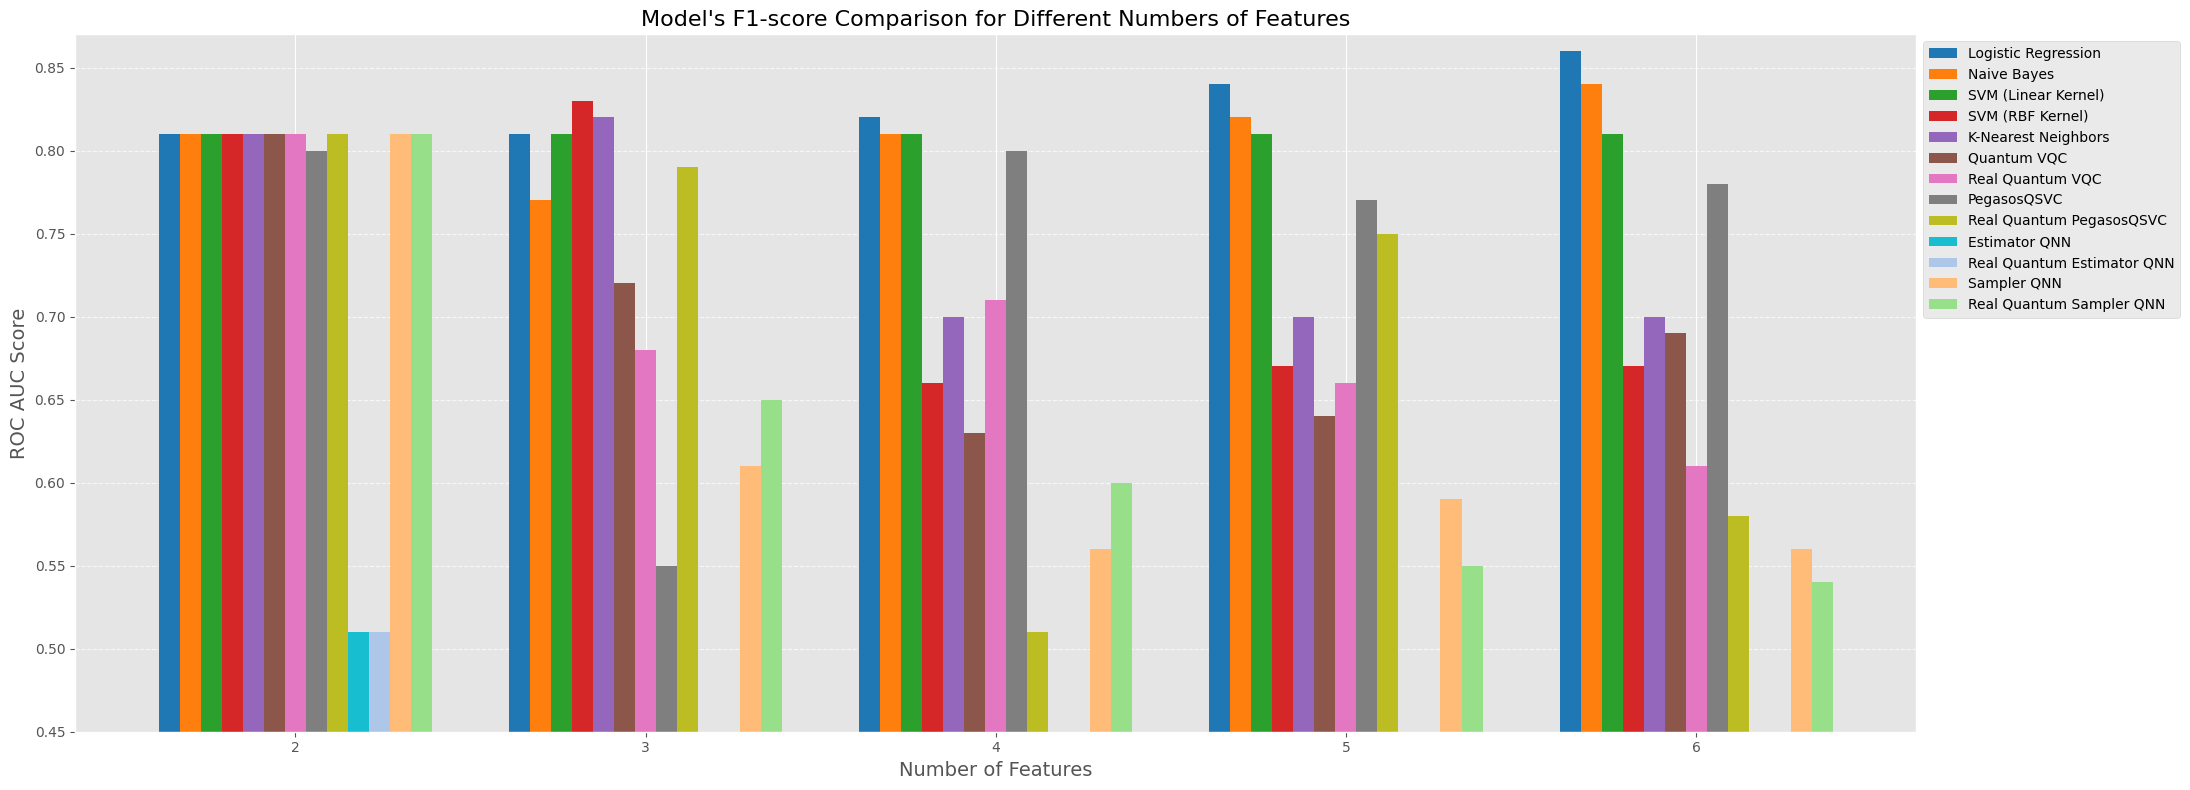

In [ ]:
# Save configuration
plot_filename = f"{PLOT_DIR}/{PLOT_PREFIX}_{FEATURE_COUNTS[-1]}_accuracy_comparison.{PLOT_FORMAT}"

# Approach 2: Using tableau colors (very distinct)
tableau_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5'
]

# Modified plotting code
plt.figure(figsize=(22, 8))
bar_width = 0.06
for i, model in enumerate(model_names):
    scores = [all_results[n][model][0]["accuracy"] for n in feature_counts]
    x = np.arange(len(feature_counts))
    plt.bar(x + i * bar_width,
           scores,
           bar_width,
           label=model,
           color=tableau_colors[i]) 

plt.title("Model's F1-score Comparison for Different Numbers of Features", fontsize=16)
plt.xlabel("Number of Features", fontsize=14)
plt.ylabel("ROC AUC Score", fontsize=14)
plt.ylim(0.45, 0.87)
plt.xticks(x + (len(model_names) - 1) * bar_width / 2, feature_counts)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

if SAVE_PLOTS:
    plt.savefig(plot_filename, dpi=PLOT_DPI, bbox_inches='tight')
    print(f"Plot saved: {plot_filename}")

plt.show()

Plot saved: plots/heartdisease__6_precision_comparison.png


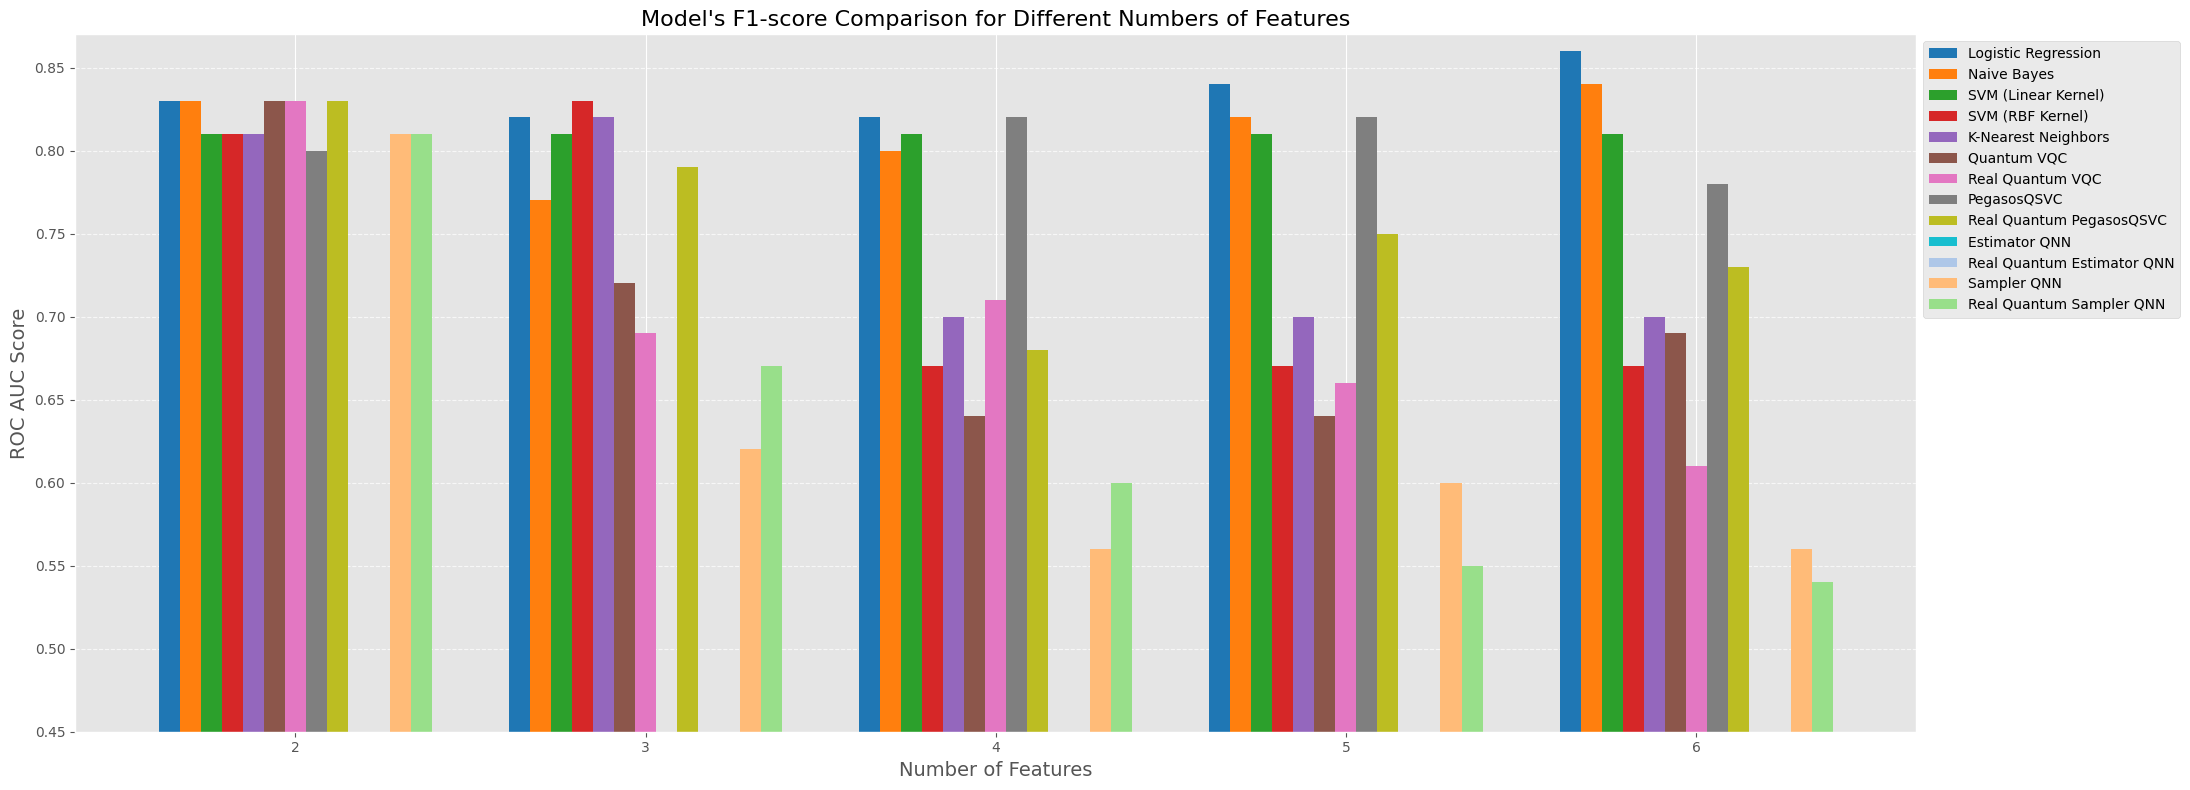

In [ ]:
# Save configuration
plot_filename = f"{PLOT_DIR}/{PLOT_PREFIX}_{FEATURE_COUNTS[-1]}_precision_comparison.{PLOT_FORMAT}"

# Approach 2: Using tableau colors (very distinct)
tableau_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5'
]

# Modified plotting code
plt.figure(figsize=(22, 8))
bar_width = 0.06
for i, model in enumerate(model_names):
    scores = [all_results[n][model][1]["precision"] for n in feature_counts]
    x = np.arange(len(feature_counts))
    plt.bar(x + i * bar_width,
           scores,
           bar_width,
           label=model,
           color=tableau_colors[i]) 

plt.title("Model's F1-score Comparison for Different Numbers of Features", fontsize=16)
plt.xlabel("Number of Features", fontsize=14)
plt.ylabel("ROC AUC Score", fontsize=14)
plt.ylim(0.45, 0.87)
plt.xticks(x + (len(model_names) - 1) * bar_width / 2, feature_counts)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

if SAVE_PLOTS:
    plt.savefig(plot_filename, dpi=PLOT_DPI, bbox_inches='tight')
    print(f"Plot saved: {plot_filename}")

plt.show()

Plot saved: plots/heartdisease__6_recall_comparison.png


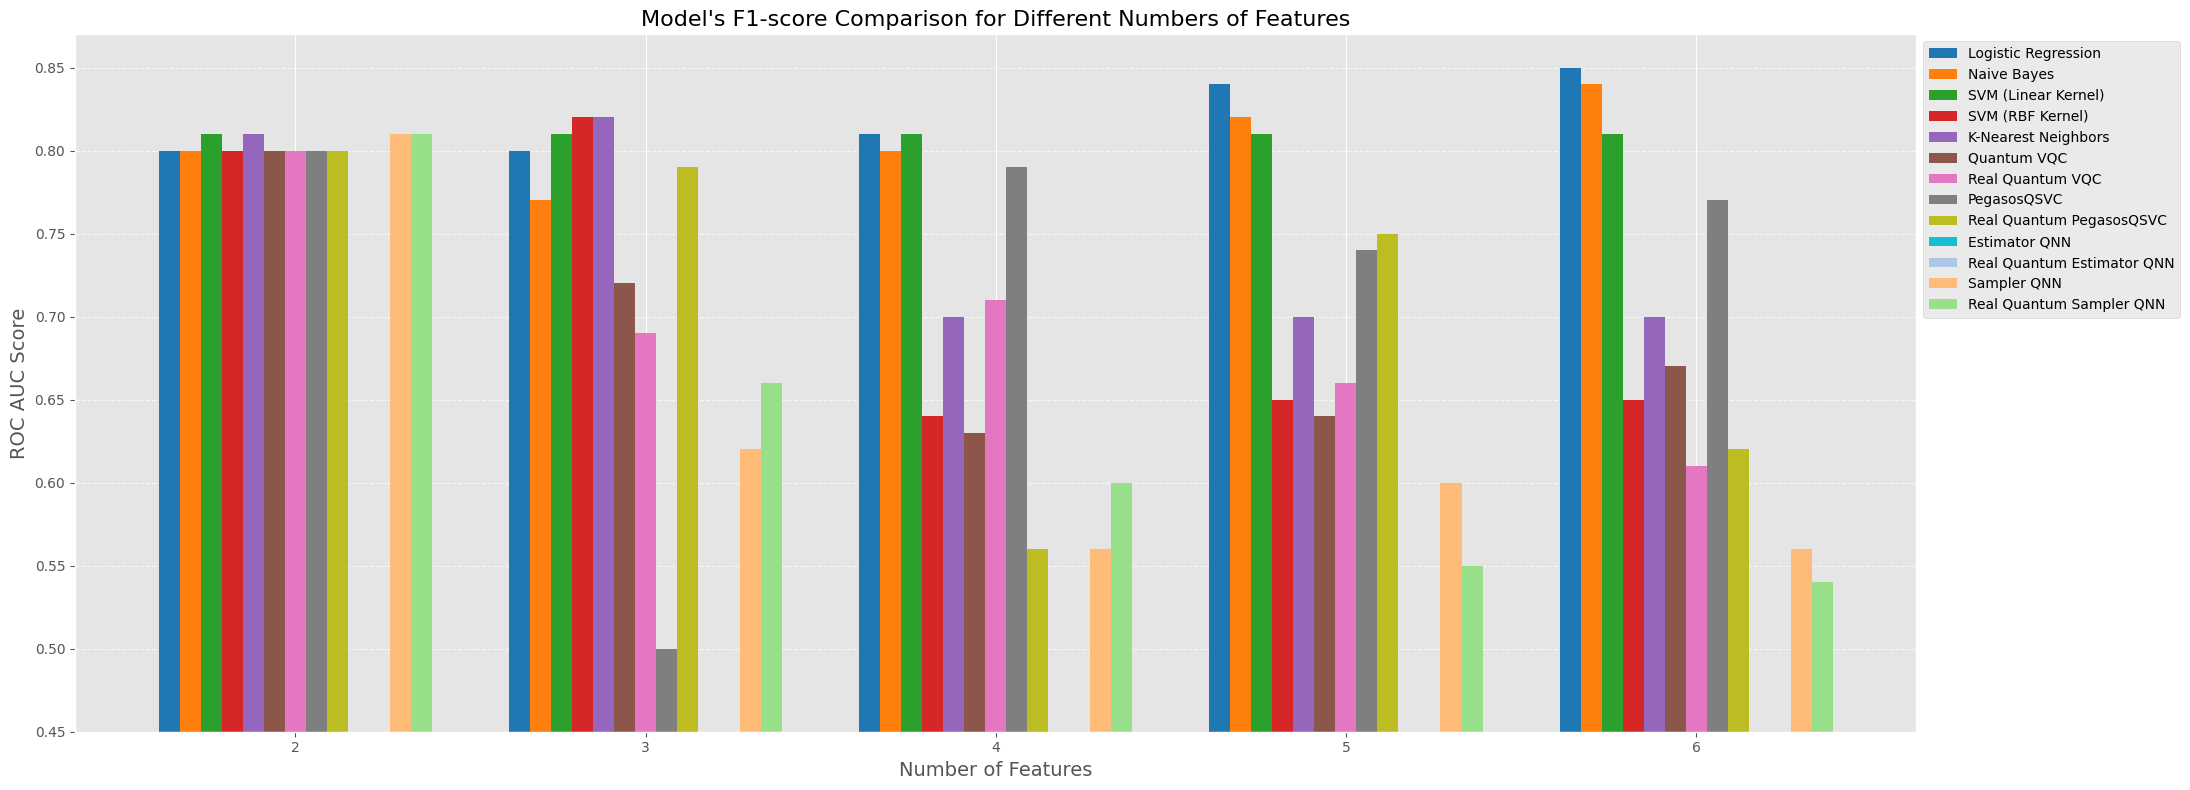

In [ ]:
# Save configuration
plot_filename = f"{PLOT_DIR}/{PLOT_PREFIX}_{FEATURE_COUNTS[-1]}_recall_comparison.{PLOT_FORMAT}"

# Approach 2: Using tableau colors (very distinct)
tableau_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5'
]

# Modified plotting code
plt.figure(figsize=(22, 8))
bar_width = 0.06
for i, model in enumerate(model_names):
    scores = [all_results[n][model][2]["recall"] for n in feature_counts]
    x = np.arange(len(feature_counts))
    plt.bar(x + i * bar_width,
           scores,
           bar_width,
           label=model,
           color=tableau_colors[i]) 

plt.title("Model's F1-score Comparison for Different Numbers of Features", fontsize=16)
plt.xlabel("Number of Features", fontsize=14)
plt.ylabel("ROC AUC Score", fontsize=14)
plt.ylim(0.45, 0.87)
plt.xticks(x + (len(model_names) - 1) * bar_width / 2, feature_counts)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

if SAVE_PLOTS:
    plt.savefig(plot_filename, dpi=PLOT_DPI, bbox_inches='tight')
    print(f"Plot saved: {plot_filename}")

plt.show()

Plot saved: plots/heartdisease__6_f1-score_comparison.png


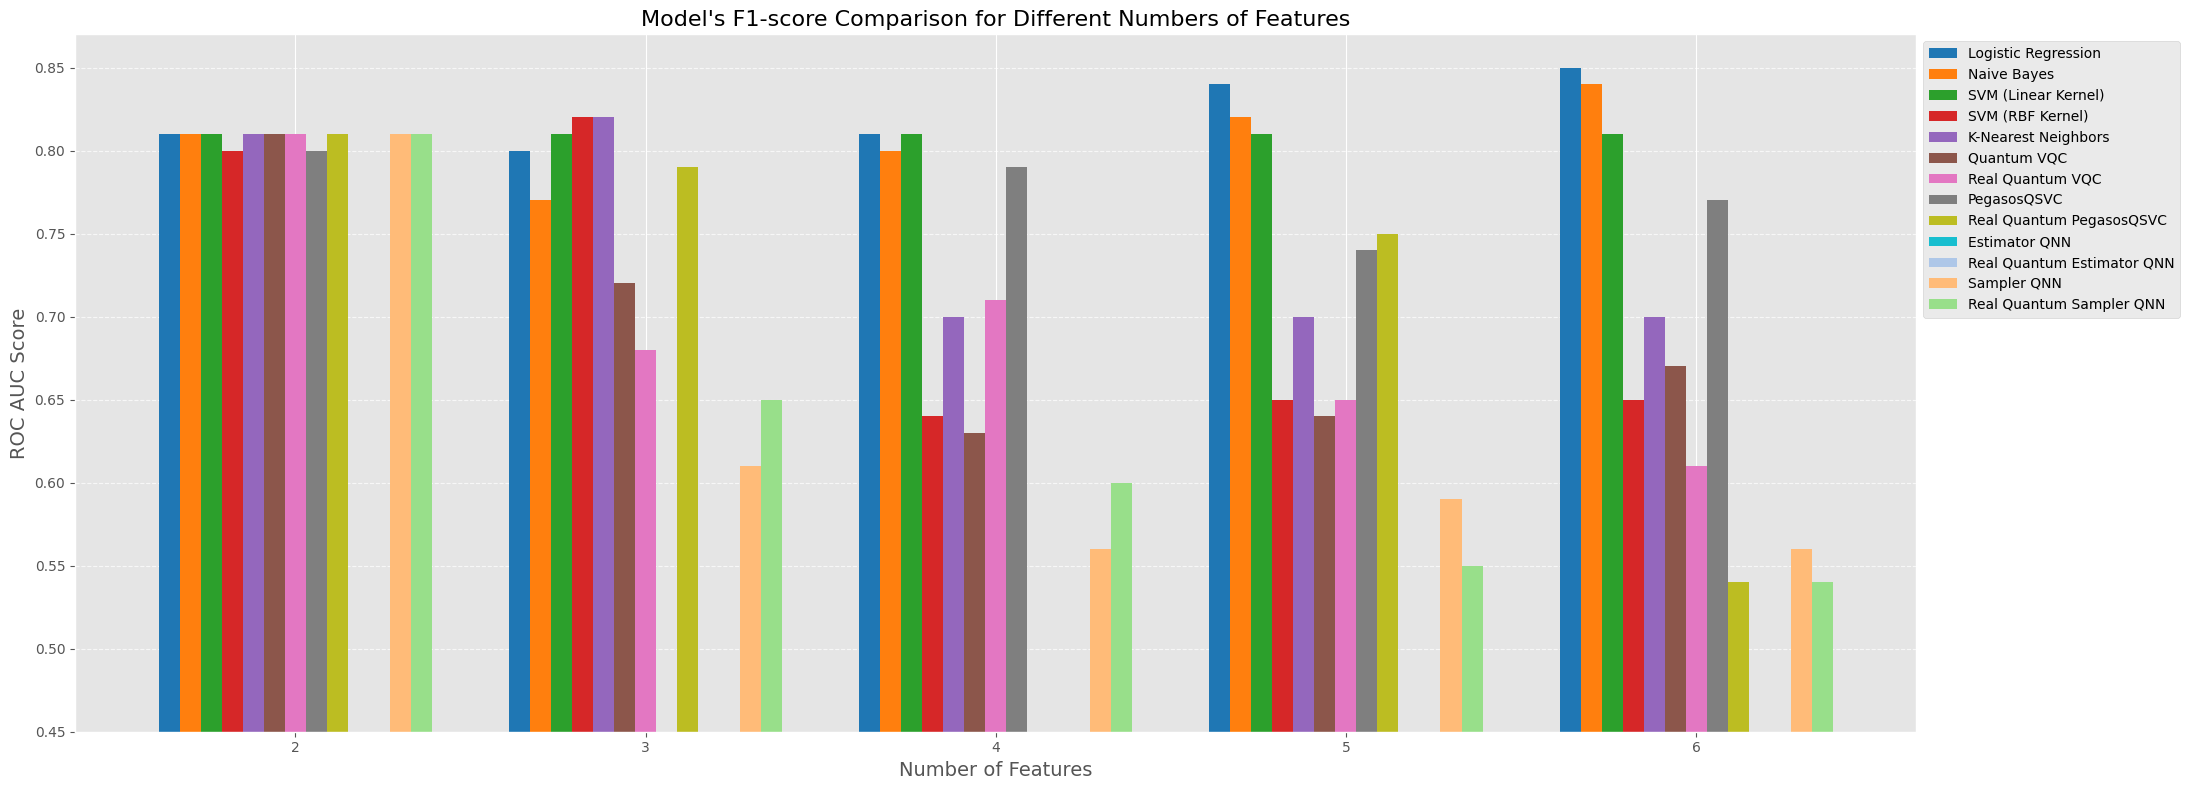

In [ ]:
# Save configuration
plot_filename = f"{PLOT_DIR}/{PLOT_PREFIX}_{FEATURE_COUNTS[-1]}_f1-score_comparison.{PLOT_FORMAT}"

# Approach 2: Using tableau colors (very distinct)
tableau_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5'
]

# Modified plotting code
plt.figure(figsize=(22, 8))
bar_width = 0.06
for i, model in enumerate(model_names):
    scores = [all_results[n][model][3]["f1-score"] for n in feature_counts]
    x = np.arange(len(feature_counts))
    plt.bar(x + i * bar_width,
           scores,
           bar_width,
           label=model,
           color=tableau_colors[i]) 

plt.title("Model's F1-score Comparison for Different Numbers of Features", fontsize=16)
plt.xlabel("Number of Features", fontsize=14)
plt.ylabel("ROC AUC Score", fontsize=14)
plt.ylim(0.45, 0.87)
plt.xticks(x + (len(model_names) - 1) * bar_width / 2, feature_counts)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

if SAVE_PLOTS:
    plt.savefig(plot_filename, dpi=PLOT_DPI, bbox_inches='tight')
    print(f"Plot saved: {plot_filename}")

plt.show()

In [ ]:
import tutorial_magics


%qiskit_version_table